# Final B3 - Grupo 1
Análisis de DF de clientes bancarios para detectar bajas en un periodo de dos meses aplicando modelos predictivos.

Notebook 2/3 = Selección de Modelos

Integrantes:

Pascuccio, José (1017995)

Bugarin Carlos Maximiliano (82125)

Calda Ariel Gustavo (1158887)

Capello Juan Andrés (1158799)

Ricci Cecilia (1160479)

Siracusa Angel Jonatán (1160480)

Nievas Ivana (1157295)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta,date
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics



from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV



### **Función Threshold Optimo**

La función recibe como parámetros:
*   array de probabilidades generado por el modelo a evaluar
*   array con resultado de clase real

La función evalúa a qué threshold se genera la mayor ganancia y devuelve dichos valores.



In [ ]:
def ThresholdOptimo(y_test_pb, y_test):
  # Los array recibidos se cargan en DF y se arma un DF total
  dfp = pd.DataFrame(y_test_pb)
  dfy = pd.DataFrame(y_test)
  dfy = dfy.reset_index()
  dfy = dfy.drop(['index'], axis=1)
  dfpmodelo = pd.concat([dfy, dfp], axis=1)
  dfpmodelo.columns = ['Clase', 'Probabilidad']
  # Se genera una columna Ganancia
  dfpmodelo['Ganancia'] = 0

  # Ordeno la columna de probabilidad de mayor a menor
  dfpmodelo = dfpmodelo.sort_values('Probabilidad', ascending=False)
  dfpmodelo = dfpmodelo.reset_index()

  # Se llena la columna Ganancia sumando la ganacia de cada registro:
  # Si la Clase = 1 suma 4900, Clase = 0 resta 100
  ganacum = 0
  for i in dfpmodelo.index:
    if dfpmodelo['Clase'][i] == 1:
      gan = 4900
    else:
      gan = -100
    ganacum = ganacum + gan
    dfpmodelo['Ganancia'][i] = ganacum

  # Ordeno la columna de Ganancia de mayor a menor y tomo el valor mayor
  dfpmodelo = dfpmodelo.sort_values('Ganancia', ascending=False).head(1)
  dfpmodelo = dfpmodelo.reset_index()
  ganancia = dfpmodelo['Ganancia'][0]
  threshold = dfpmodelo['Probabilidad'][0]

  return (ganancia, threshold)


In [ ]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#Carga DF preprocesado

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Grupo1/B3/Final'


Mounted at /content/drive


In [ ]:
def cargar_dataframe(Archivo):
  df2 = pd.read_csv(Archivo)
  X = df2.drop(['target_bin', 'foto_mes', 'numero_de_cliente'], axis=1).values 
  y = df2['target_bin']

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
  return df2, X_train, X_test, y_train, y_test

In [ ]:
#df2, X_train, X_test, y_train, y_test = cargar_dataframe('/content/drive/MyDrive/DataScience/B3/201402_reduccion_minima.csv')
#df2, X_train, X_test, y_train, y_test = cargar_dataframe('/content/drive/MyDrive/B3/Final/DF34.csv')
df2, X_train, X_test, y_train, y_test = cargar_dataframe('/content/drive/MyDrive/B3/Final/DF150.csv')

## Modelo clasificación - Decision Tree

In [ ]:
# summarize the new class distribution
df2.groupby('target_bin').size()

target_bin
0    181203
1       778
dtype: int64

In [ ]:
print(f'X_Train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_Train: (136485, 148)
X_test: (45496, 148)
y_train: (136485,)
y_test: (45496,)


Definicion de funciones

In [ ]:
def DecisionTree_entrena (x, y, criterio, depth, weight):
  # Crear Arbol de decision con profundidad indicada por parametro
  decision_tree = tree.DecisionTreeClassifier(criterion=criterio,
                                              min_samples_split=20,
                                              min_samples_leaf=5,
                                              max_depth = depth,
                                              class_weight=weight)
  decision_tree.fit(x, y)
  return decision_tree


def DecisionTree_visualiza (decision_tree, depth, x, y, nombresClase, features ): 
  # exportar el modelo a archivo .dot
  with open(r"tree1.dot", 'w') as f:
      f = tree.export_graphviz(decision_tree,
                                out_file=f,
                                max_depth = depth,
                                impurity = True,
                                feature_names = features,
                                class_names = nombresClase,
                                rounded = True,
                                filled= True )
          
  # Convertir el archivo .dot a png para poder visualizarlo
  check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
  acc_decision_tree = round(decision_tree.score(x, y) * 100, 2)
  print('precisión alcanzada por nuestro árbol:',acc_decision_tree)
  return "tree1.png"

def dtree_grid_search(X,y,nfolds):
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15), 'class_weight':['balanced']}
    dtree_model=DecisionTreeClassifier()
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    dtree_gscv.fit(X, y)
    return dtree_gscv

def DecisionTree_predecir_informar(decision_tree, X_train, y_train, X_test, y_test):
  y_train_pred = decision_tree.predict(X_train)
  y_test_pred = decision_tree.predict(X_test)
  print('Matriz de confusion de train:')
  print(confusion_matrix(y_train, y_train_pred))
  print(' ')
  print('Matriz de confusion de test:')

  threshold = 0.02
  y_pred = (decision_tree.predict_proba(X_test)[:, 1] > threshold).astype('float')
  print(confusion_matrix(y_test, y_pred))

  print('')
  print('Accuracy Train:',accuracy_score(y_train, y_train_pred))
  print('Accuracy Test:',accuracy_score(y_test, y_test_pred))
  print(' ')
  print('Recall Train:',recall_score(y_train, y_train_pred))
  print('Recall Test:',recall_score(y_test, y_test_pred))
  print(' ')
  print('Precision Train:',precision_score(y_train, y_train_pred))
  print('Precision Test:',precision_score(y_test, y_test_pred))

  y_score1 = decision_tree.predict_proba(X_test)[:,1]
  # Create true and false positive rates
  false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
  print(' ')
  print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score1))
  # Plot ROC curves
  plt.subplots(1, figsize=(10,10))
  plt.title('Receiver Operating Characteristic - DecisionTree')
  plt.plot(false_positive_rate1, true_positive_rate1)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return y_pred

Entrena con los mejores hierparametros obtenidos con el GridSearch

In [ ]:
#Entrena con los mejores parametros obtenidos con el GridSearch
decision_tree = dtree_grid_search(X_train,y_train, 5)

print('Best Criterion:', decision_tree.best_params_)
#Best Criterion: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 14}


Best Criterion: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 14}


Realiza las predicciones

Matriz de confusion de train:
[[126931   8958]
 [     2    594]]
 
Matriz de confusion de test:
[[41935  3379]
 [   63   119]]

Accuracy Train: 0.934351760266696
Accuracy Test: 0.9293784068929136
 
Recall Train: 0.9966442953020134
Recall Test: 0.6538461538461539
 
Precision Train: 0.062185929648241205
Precision Test: 0.03640256959314775
 
roc_auc_score for DecisionTree:  0.7294984278201384


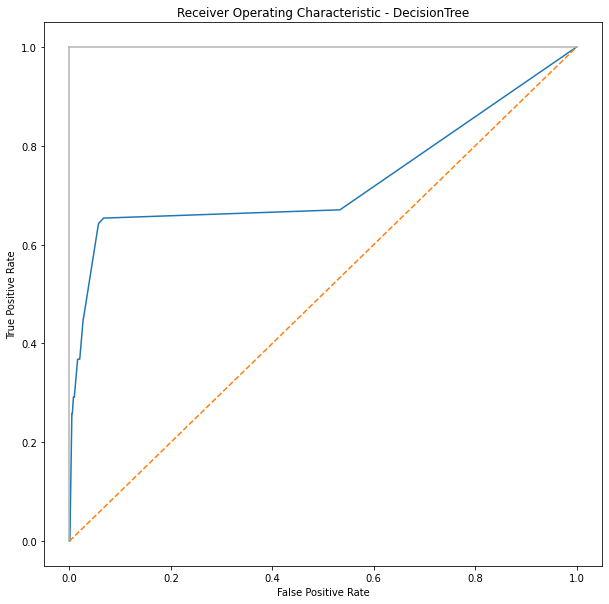

In [ ]:
y_pred = DecisionTree_predecir_informar(decision_tree, X_train, y_train, X_test, y_test)
                      

In [ ]:
predicciones = decision_tree.predict_proba(X_test)[:,1]
predicciones_bin = decision_tree.predict(X_test)

In [ ]:
ganancia, threshold = ThresholdOptimo(predicciones, y_test)

print('Ganancia Estimada: %.0f \nThreshold: %.4f' % (ganancia, threshold))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Ganancia Estimada: 314800 
Threshold: 0.8097


In [ ]:
predicciones_20 = []
for n in predicciones:
    predicciones_20.append(format(n, ".20f")) 

y_pred_s = pd.Series(predicciones_20, index=y_test.index.tolist())
y_pred_bin_s = pd.Series(predicciones_bin, index=y_test.index.tolist())

In [ ]:
#Detalle de probabilidades
finalDf= pd.concat([
df2.loc[y_test.index.tolist(),['numero_de_cliente','target_bin']],
pd.DataFrame(y_pred_s, columns=['Pred']),
pd.DataFrame(y_pred_bin_s, columns=['Proba'])
], axis=1)
finalDf

,numero_de_cliente,target_bin,Pred,Proba
18909,7505074,0,0.00000000000000000000,0
75459,17925709,0,0.00363969911634350139,0
172951,41097326,0,0.00000000000000000000,0
16316,7255698,0,0.00363969911634350139,0
143242,30057908,0,0.00000000000000000000,0
...,...,...,...,...
126650,26335728,0,0.00363969911634350139,0
127905,26556502,0,0.00363969911634350139,0
127622,26509225,0,0.00000000000000000000,0
92117,21433251,0,0.00000000000000000000,0


In [ ]:
finalDf['Proba'].astype(float)

18909     0.0
75459     0.0
172951    0.0
16316     0.0
143242    0.0
         ... 
126650    0.0
127905    0.0
127622    0.0
92117     0.0
73809     0.0
Name: Proba, Length: 45496, dtype: float64

In [ ]:
finalDf.to_csv('/content/drive/MyDrive/B3/Final/DTREE_GS_c150.csv')

Ejecucion del modelo co hiperparametros fijos

precisión alcanzada por nuestro árbol: 86.34


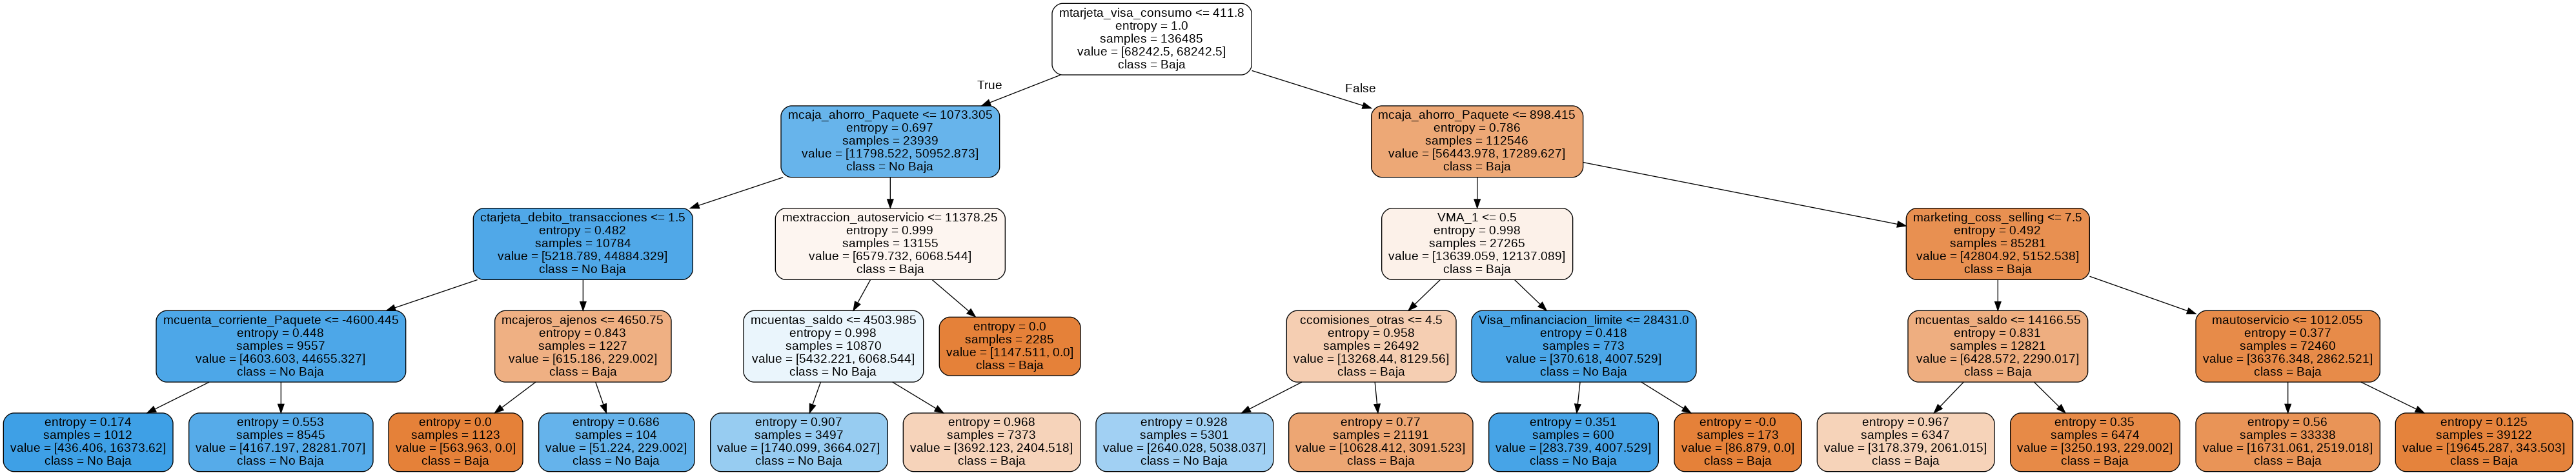

In [ ]:
#Ejecutar el desicion tree con hiperparametros fijos

nombresClase = ['Baja', 'No Baja']
features = list(df2.drop(['target_bin', 'foto_mes', 'numero_de_cliente'], axis=1))
depth = 4

decision_tree = DecisionTree_entrena(X_train, y_train, 'entropy', depth, 'balanced')

#Visualizarlo
PImage(DecisionTree_visualiza(decision_tree, depth, X_train, y_train, nombresClase, features))

Matriz de confusion de train:
[[117333  18556]
 [    93    503]]
 
Matriz de confusion de test:
[[14091 31223]
 [    9   173]]

Accuracy Train: 0.8633622742425907
Accuracy Test: 0.8628670652365044
 
Recall Train: 0.8439597315436241
Recall Test: 0.8076923076923077
 
Precision Train: 0.026391730940762893
Precision Test: 0.023145961265942372
 
roc_auc_score for DecisionTree:  0.8802929812827416


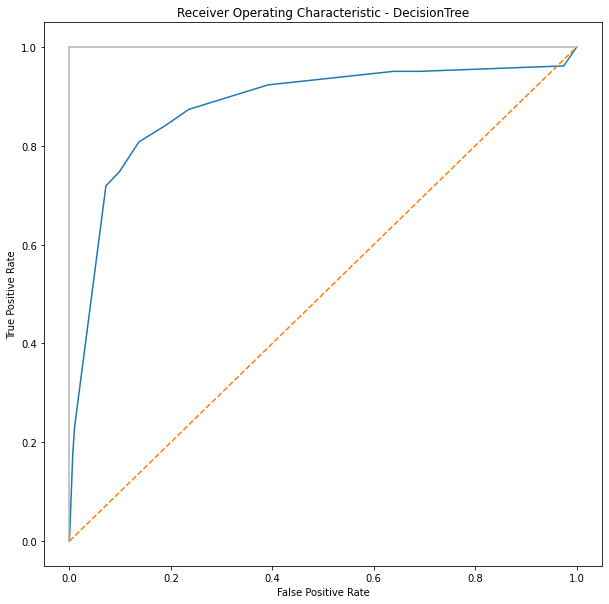

In [ ]:
y_pred = DecisionTree_predecir_informar(decision_tree, X_train, y_train, X_test, y_test)

In [ ]:
predicciones2 = decision_tree.predict_proba(X_test)[:,1]
predicciones2_bin = decision_tree.predict(X_test) 

In [ ]:
ganancia, threshold = ThresholdOptimo(predicciones2, y_test)

print('Ganancia Estimada: %.0f \nThreshold: %.4f' % (ganancia, threshold))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Ganancia Estimada: 317900 
Threshold: 0.8716


In [ ]:
predicciones2_20 = []
for n in predicciones2:
    predicciones2_20.append(format(n, ".20f")) 

y_pred_s2 = pd.Series(predicciones2_20, index=y_test.index.tolist())
y_pred_bin_s2 = pd.Series(predicciones2_bin, index=y_test.index.tolist()) 

In [ ]:
finalDf2= pd.concat([
df2.loc[y_test.index.tolist(),['numero_de_cliente','target_bin']],
pd.DataFrame(y_pred_s2, columns=['Pred']),
pd.DataFrame(y_pred_bin_s2, columns=['Proba'])
], axis=1)
finalDf2

,numero_de_cliente,target_bin,Pred,Proba
18909,7505074,0,0.65615968239811151008,1
75459,17925709,0,0.01718475861257339268,0
172951,41097326,0,0.06582031391905199258,0
16316,7255698,0,0.13085756241362694885,0
143242,30057908,0,0.22533071354608105730,0
...,...,...,...,...
126650,26335728,0,0.01718475861257339268,0
127905,26556502,0,0.01718475861257339268,0
127622,26509225,0,0.22533071354608105730,0
92117,21433251,0,0.39336895629943130492,0


In [ ]:
finalDf2['Proba'].astype(float)

18909     1.0
75459     0.0
172951    0.0
16316     0.0
143242    0.0
         ... 
126650    0.0
127905    0.0
127622    0.0
92117     0.0
73809     0.0
Name: Proba, Length: 45496, dtype: float64

In [ ]:
finalDf2.to_csv('/content/drive/MyDrive/B3/Final/DTREE_c150.csv')

##Conclusion tras aplicar el Desicion Tree
Despues de aplicar el Desicion Tree con los hiperparametros obtenidos tras aplicar el GridSearch, y el modelo con

### Modelo Clasificación - KNN (K-Nearest Neighbors)


Teniendo las features transformadas y seleccionadas entrenamos un modelo KNN.
Tomamos un 75% de los datos para entrenamiento y el 25% restante para test.
Entrenamos el modelo 3 veces:

    1. Dataset con el total de los datos (181981 filas)
    2. Dataset con menos porcentaje de no-baja: con 50000 no-baja y 778 baja (50778 filas)
    3. Dataset balanceado: con 800 no-baja y 778 baja (1578 filas)

Generación de los 3 datasets y separación en Train/Test.
Solo usaremos el test del Total para testear el modelo.

In [ ]:
print(f'X_Train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_Train: (136485, 150)
X_test: (45496, 150)
y_train: (136485,)
y_test: (45496,)


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181981 entries, 0 to 181980
Columns: 151 entries, Unnamed: 0 to VCE_19
dtypes: float64(70), int64(81)
memory usage: 209.6 MB


In [ ]:
df2_201402_all_records = df2
#Acá tenemos todos los registros (181981)

In [ ]:
df2_201402_yes = df2.loc[df2.target_bin == 1]
#Acá tenemos todos los DE BAJA (778)

In [ ]:
df2_201402_no = df2.loc[df2.target_bin == 0]
#Acá tenemos todos los NO BAJA (181203)

In [ ]:
df2_201402_no_50000 = df2_201402_no.sample(n = 50000)
#Acá traemos una muestra de 50000 NO BAJA

In [ ]:
df50000 = [df2_201402_no_50000, df2_201402_yes]
df2_201402_50000_to_predict = pd.concat(df50000)
df2_201402_50000_to_predict.info()
#Concatenamos los 50000 NO BAJA y los 778 BAJA (TOTAL 50778)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50778 entries, 179041 to 181900
Columns: 151 entries, Unnamed: 0 to VCE_19
dtypes: float64(70), int64(81)
memory usage: 58.9 MB


In [ ]:
df2_201402_800_no = df2_201402_no.sample(n = 800)
#Acá traemos una muestra de 800 NO BAJA
dfBALANCED = [df2_201402_800_no, df2_201402_yes]
#Concatenamos los 800 NO BAJA y los 778 BAJA (TOTAL 1578)
df2_201402_balanced_to_predict = pd.concat(dfBALANCED)
df2_201402_balanced_to_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1578 entries, 10563 to 181900
Columns: 151 entries, Unnamed: 0 to VCE_19
dtypes: float64(70), int64(81)
memory usage: 1.8 MB


In [ ]:
#Preparamos X e y - TOTAL DE DATOS
Xtotal = df2.drop(['target_bin'] , axis='columns')
ytotal = df2.target_bin

#Separamos datos en train y test
X_trainTotal, X_testTotal, y_trainTotal, y_testTotal = train_test_split(Xtotal, ytotal,
                                                    random_state=1,
                                                    stratify=ytotal)  

In [ ]:
#Preparamos X e y -  50778 REGISTROS
X50000 = df2_201402_50000_to_predict.drop(['target_bin'] , axis='columns')
y50000 = df2_201402_50000_to_predict.target_bin

#Separamos en train y test
X_train50000, X_test50000, y_train50000, y_test50000 = train_test_split(X50000, y50000,
                                                    random_state=1,
                                                    stratify=y50000) 

In [ ]:
#Preparamos X e y - 1578 REGISTROS - BALANCED
Xbalanced = df2_201402_balanced_to_predict.drop(['target_bin'] , axis='columns')
ybalanced = df2_201402_balanced_to_predict.target_bin

#Separamos en train y test
X_trainBalanced, X_testBalanced, y_trainBalanced, y_testBalanced = train_test_split(Xbalanced, ybalanced,
                                                    random_state=1,
                                                    stratify=ybalanced)   

###1.Dataset con TODOS los Registros
Entrenamos el modelo KNN con los 3 datasets de Train y lo testeamos con el Test del total.

Estandarizamos y buscamos los mejores parámetros.

In [ ]:
#Estandarizo los datos
standardizer = StandardScaler()
X_std = standardizer.fit_transform(Xtotal)

In [ ]:
#Parametros para el GridSearchCV 
knn = KNeighborsClassifier(metric='euclidean', n_jobs=-1)

#Definición del pipeline
pipe = Pipeline([('standardizer', standardizer), ('knn', knn)])

#Definimos el search_space para testear los distintos valores de k.
search_space = [{'knn__n_neighbors': [1, 3, 5, 7, 10]}]

In [ ]:
#Creamos la rejlla de optimización (GridSearchCV) y ajustamos el modelo - con scoring='roc_auc'
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0, scoring='roc_auc').fit(X_std, ytotal)

In [ ]:
#Del modelo clasificador obtenemos el mejor valor de K
clf.best_estimator_.get_params()['knn__n_neighbors']

In [ ]:
##Usamos el mejor valor de K estimado = 10
knn = KNeighborsClassifier(n_neighbors=10)

In [ ]:
#Entreno el modelo sobre Train
clf = knn.fit(X_trainTotal, y_trainTotal)
#Scoreo sobre Test
clf.score(X_testTotal, y_testTotal)

0.9957139089150695

In [ ]:
#Predict en Train y Test
y_train_total_pred = clf.predict(X_trainTotal)
y_test_total_pred = clf.predict(X_testTotal)

In [ ]:
#Calculamos Probabilidades Asociadas
y_test_total_proba = clf.predict_proba(X_testTotal)[:,1]

In [ ]:
#Vemos matriz de confusión en Train
confusion_matrix(y_trainTotal, y_train_total_pred)

array([[135902,      0],
       [   583,      0]])

In [ ]:
#Vemos la matriz de confusión en Test
confusion_matrix(y_testTotal, y_test_total_pred)

array([[45301,     0],
       [  195,     0]])

In [ ]:
#Ahora obtenemos Recall y Precision
print('Accuracy')
print('Train:',accuracy_score(y_trainTotal, y_train_total_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_trainTotal, y_train_total_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_trainTotal, y_train_total_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.9957284683298531
Test: 0.9957139089150695
 
Recall
Train: 0.0
Test: 0.0
 
Precision
Train: 0.0
Test: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###  2.Dataset con 50778 Registros

In [ ]:
#Entreno el modelo sobre Train
clf = knn.fit(X_train50000, y_train50000)
#Scoreo sobre Test
clf.score(X_testTotal, y_testTotal)

0.9957139089150695

In [ ]:
#Predict en Train y Test
y_train_50000_pred = clf.predict(X_train50000)
y_test_total_pred = clf.predict(X_testTotal)

In [ ]:
#Calculamos Probabilidades Asociadas
y_test_total_proba = clf.predict_proba(X_testTotal)[:,1]

In [ ]:
#Vemos la matriz de confusión en Train
confusion_matrix(y_train50000, y_train_50000_pred)

array([[37500,     0],
       [  583,     0]])

In [ ]:
#Vemos la matriz de confusión en Test
confusion_matrix(y_testTotal, y_test_total_pred)

array([[45301,     0],
       [  195,     0]])

In [ ]:
#Ahora obtenemos Recall y Precision
print('Accuracy')
print('Train:',accuracy_score(y_train50000, y_train_50000_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_train50000, y_train_50000_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_train50000, y_train_50000_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.984691332090434
Test: 0.9957139089150695
 
Recall
Train: 0.0
Test: 0.0
 
Precision
Train: 0.0
Test: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###3.Dataset Balanceado con 1578 Registros

In [ ]:
#Entreno el modelo sobre Train
clf = knn.fit(X_trainBalanced, y_trainBalanced)
#Scoreo sobre Test
clf.score(X_testTotal, y_testTotal)

0.5896562335150343

In [ ]:
#Predict en Training y Test
y_train_balanced_pred = clf.predict(X_trainBalanced)
y_test_total_pred = clf.predict(X_testTotal)

In [ ]:
#Calculamos Probabilidades Asociadas
y_test_total_proba = clf.predict_proba(X_testTotal)[:,1]

In [ ]:
#Vemos la matriz de confusión en Train
confusion_matrix(y_trainBalanced, y_train_balanced_pred)

array([[420, 180],
       [194, 389]])

In [ ]:
#Vemos la matriz de confusión en Test
confusion_matrix(y_testTotal, y_test_total_pred)

array([[26703, 18598],
       [   71,   124]])

In [ ]:
#Ahora obtenemos Recall y Precision
print('Accuracy')
print('Train:',accuracy_score(y_trainBalanced, y_train_balanced_pred))
print('Test:',accuracy_score(y_testTotal, y_test_total_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_trainBalanced, y_train_balanced_pred))
print('Test:',recall_score(y_testTotal, y_test_total_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_trainBalanced, y_train_balanced_pred))
print('Test:',precision_score(y_testTotal, y_test_total_pred))

Accuracy
Train: 0.68385460693153
Test: 0.5896562335150343
 
Recall
Train: 0.6672384219554031
Test: 0.6358974358974359
 
Precision
Train: 0.6836555360281195
Test: 0.0066232240145283625


###CURVA ROC (Modelo KNN)
Habiendo pasado por 3 entrenamientos con distinto balanceo para el modelo KNN, nos quedamos con el caso de los datos Balanceados. Concluimos que el modelo KNN no es un gran predictor para este caso de negocio.


*************************Ploteo de Curva ROC - Modelo KNN*************************
roc_auc_score for KNeighborsClassifier:  0.6538270791554384


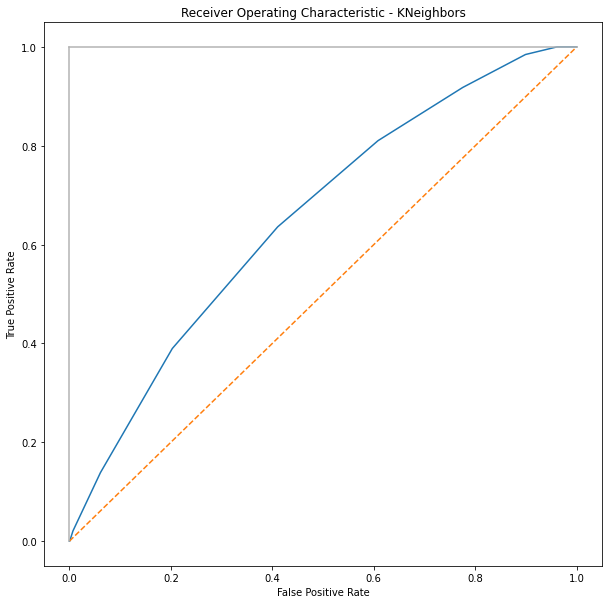

In [ ]:
print()
print(format('Ploteo de Curva ROC - Modelo KNN','*^82'))

import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Get predicted probabilities
y_score1 = clf.predict_proba(X_testTotal)[:,1]

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_testTotal, y_score1)
print('roc_auc_score for KNeighborsClassifier: ', roc_auc_score(y_testTotal, y_score1))

# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - KNeighbors')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###Predicciones - Modelo KNN

In [ ]:
print(X_testTotal)

In [ ]:
KNN_y_pred = clf.predict_proba(X_testTotal)[:, 1] 
KNN_y_pred_bin = clf.predict(X_testTotal) 

In [ ]:
KNN_y_pred_20 = []
for n in KNN_y_pred:
    KNN_y_pred_20.append(format(n, ".20f"))  
    
KNN_y_pred_s = pd.Series(KNN_y_pred_20, index=y_testTotal.index.tolist())
KNN_y_pred_bin_s = pd.Series(KNN_y_pred_bin, index=y_testTotal.index.tolist())

In [ ]:
#Detalle de probabilidades
KNN_finalDf= pd.concat([
df2.loc[y_testTotal.index.tolist(),['numero_de_cliente','target_bin']],
pd.DataFrame(KNN_y_pred_bin_s, columns=['Pred']),
pd.DataFrame(KNN_y_pred_s, columns=['Proba'])
], axis=1)
KNN_finalDf

In [ ]:
print(KNN_finalDf.shape)

(45496, 3)


In [ ]:
#KNN_finalDf.to_csv('./proba_DF150_KNN.csv')
KNN_finalDf.to_csv('/content/drive/MyDrive/B3/Final/proba_DF150_KNN.csv')

### Conclusion KNN - Modelo Balanceado
Viendo la curva ROC y con un AUC-ROC en Test de 0.6625 no parece ser un modelo muy apto para nuestra clasificación.

Al graficar en un Excel nos da una curva de ganancia neta con pendiente negativa.

Ganancia Estimada:  $ 0
Threshold:  0.0

# -----------------------------------------------------------------------------------------------------------
# Modelos clasificación

### Regresión Logística

## Definición de funciones y estructuras

In [ ]:
#definimos función para mostrar los resultados
LOGR_LABELS = ['SE QUEDA', 'SE VA']

def mostrar_resultados(y_test, pred_y):
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns 
    from sklearn.metrics import confusion_matrix
    
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, xticklabels=LOGR_LABELS, yticklabels=LOGR_LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

## Carga DF preprocesado

In [ ]:
#LOGR_df2 = pd.read_csv('./DF150.csv')
LOGR_df2 = pd.read_csv('/content/drive/MyDrive/B3/Final/DF150.csv')


In [ ]:
# Elimino la primer columna
LOGR_df2 = LOGR_df2.loc[:, ~LOGR_df2.columns.str.contains('^Unnamed')]

In [ ]:
LOGR_df2.head(5)

,numero_de_cliente,foto_mes,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,marketing_coss_selling,tpaquete2,...,MCE_10,MCE_11,MCE_12,MCE_19,VMA_0,VMA_1,VCE_10,VCE_11,VCE_12,VCE_19
0,5609788,201402,0,224,61,237,0.00,9669.42,8,0,...,1,0,0,0,1,0,1,0,0,0
1,5609981,201402,0,227,64,196,0.00,4107.16,9,0,...,1,0,0,0,1,0,1,0,0,0
2,5610023,201402,0,536,41,91,0.00,2888.84,9,0,...,1,0,0,0,1,0,1,0,0,0
3,5610089,201402,0,545,0,237,2597.43,0.00,12,0,...,1,0,0,0,1,0,1,0,0,0
4,5610101,201402,0,1217,49,45,0.00,46303.03,11,0,...,1,0,0,0,1,0,1,0,0,0


## Obtención de variable objetivo y de variables predictoras

In [ ]:
LOGR_X = LOGR_df2.drop(['target_bin','numero_de_cliente', 'foto_mes'] , axis='columns')
LOGR_y = LOGR_df2.target_bin

## Comprobar Balanceo sobre variable objetivo

In [ ]:
print(LOGR_df2.shape)
print()
print(LOGR_df2.value_counts(LOGR_df2['target_bin'], sort = True))

(181981, 150)

target_bin
0    181203
1       778
dtype: int64


## Estandarización de los datos de entrenamiento
#### Optamos por estandarizar al principio

In [ ]:
standardizer = StandardScaler()
LOGR_X_stdr = standardizer.fit_transform(LOGR_X)

In [ ]:
LOGR_X_stdr

array([[-0.17188092, -0.82602006,  1.01509118, ..., -0.03708989,
        -0.04464508, -0.02852952],
       [-0.17188092, -0.81852087,  1.18225181, ..., -0.03708989,
        -0.04464508, -0.02852952],
       [-0.17188092, -0.04610454, -0.09931296, ..., -0.03708989,
        -0.04464508, -0.02852952],
       ...,
       [-0.17188092,  0.20886783,  0.62504973, ..., -0.03708989,
        -0.04464508, -0.02852952],
       [-0.17188092,  0.00638977, -2.38384146, ..., -0.03708989,
        -0.04464508, -0.02852952],
       [-0.17188092,  2.33863712, -2.38384146, ..., -0.03708989,
        -0.04464508, -0.02852952]])

## División entre conjunto de entrenamiento y testing

In [ ]:
LOGR_X_train, LOGR_X_test, LOGR_y_train, LOGR_y_test = train_test_split(LOGR_X_stdr, LOGR_y, random_state=1) # 75 - 25 split

In [ ]:
print(f'X_Train: {LOGR_X_train.shape}')
print(f'X_test: {LOGR_X_test.shape}')
print(f'y_train: {LOGR_y_train.shape}')
print(f'y_test: {LOGR_y_test.shape}')

X_Train: (136485, 147)
X_test: (45496, 147)
y_train: (136485,)
y_test: (45496,)


## Validación cruzada
#### Cross-validation a utilizar a lo largo de todo el modelo de Regresión Logística

In [ ]:
LOGR_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

## Construcción del algoritmos de aprendizaje

In [ ]:
algoritmos = {'LOGR': LogisticRegression(penalty='l1', solver='saga', max_iter=4000, random_state=1, multi_class='ovr')}

## ------------- TRAINING ----------------

## Selección de atributos
#### No aplica, ya viene dado en el DF

In [ ]:
LOGR_Xnew_train = LOGR_X_train
LOGR_Xnew_test = LOGR_X_test

## Definición de línea base
#### Situación actual sin balancear datos

In [ ]:
#param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
#              'max_iter':[4000, 6000]}

LOGR_param_grid = {'C':[0.01, 0.1, 1, 10]}
LOGR_model_no_bal = GridSearchCV(estimator=algoritmos['LOGR'],
                           param_grid=LOGR_param_grid,
                           scoring='roc_auc',
                           cv=LOGR_cv,
                           n_jobs=-1)

LOGR_model_no_bal.fit(LOGR_Xnew_train, LOGR_y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(max_iter=4000, multi_class='ovr',
                                          penalty='l1', random_state=1,
                                          solver='saga'),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10]},
             scoring='roc_auc')

In [ ]:
LOGR_model_no_bal.best_params_

{'C': 0.1}

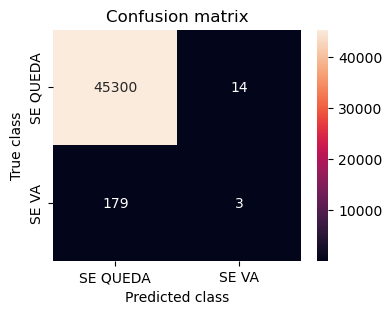

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45314
           1       0.18      0.02      0.03       182

    accuracy                           1.00     45496
   macro avg       0.59      0.51      0.51     45496
weighted avg       0.99      1.00      0.99     45496



In [ ]:
LOGR_pred_y = LOGR_model_no_bal.predict(LOGR_Xnew_test)
mostrar_resultados(LOGR_y_test, LOGR_pred_y)

In [ ]:
## Utilización de class weight para mejorar el F1

In [ ]:
LOGR_lr2 = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
LOGR_weights2 = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
LOGR_param_grid2 = {'class_weight': [{0:x, 1:1.0-x} for x in LOGR_weights2]}

#Fitting grid search to the train data with 5 folds
LOGR_gridsearch2 = GridSearchCV(estimator= LOGR_lr2, 
                          param_grid= LOGR_param_grid2,
                          cv=LOGR_cv, 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(LOGR_Xnew_train, LOGR_y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
LOGR_weigh_data = pd.DataFrame({ 'score': LOGR_gridsearch2.cv_results_['mean_test_score'], 'weight': (1- LOGR_weights2)})
sns.lineplot(LOGR_weigh_data['weight'], LOGR_weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

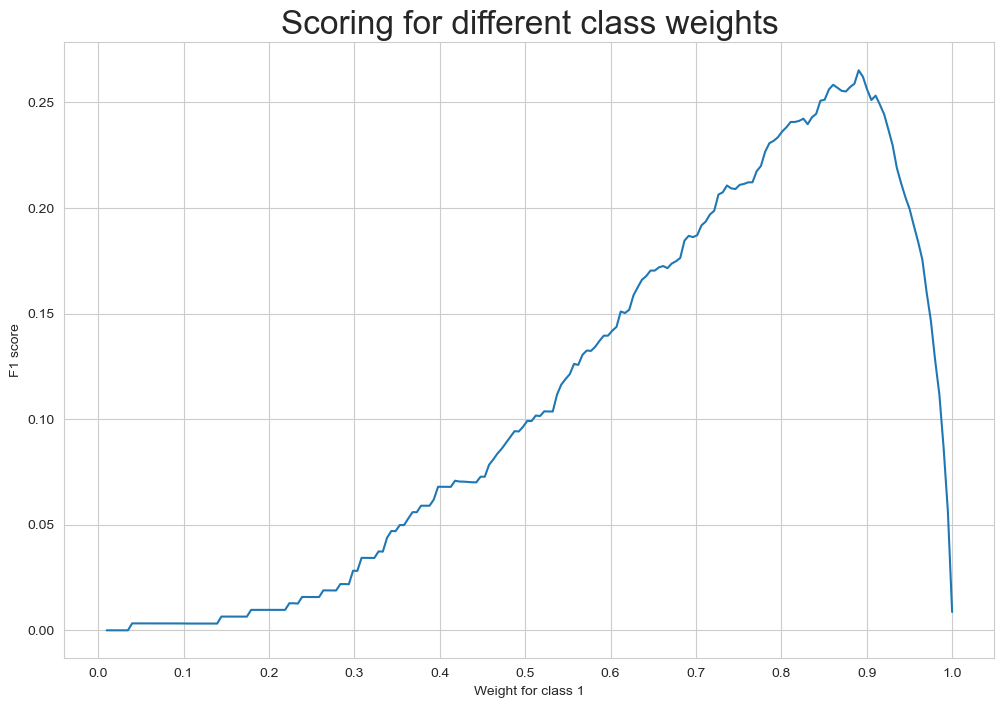

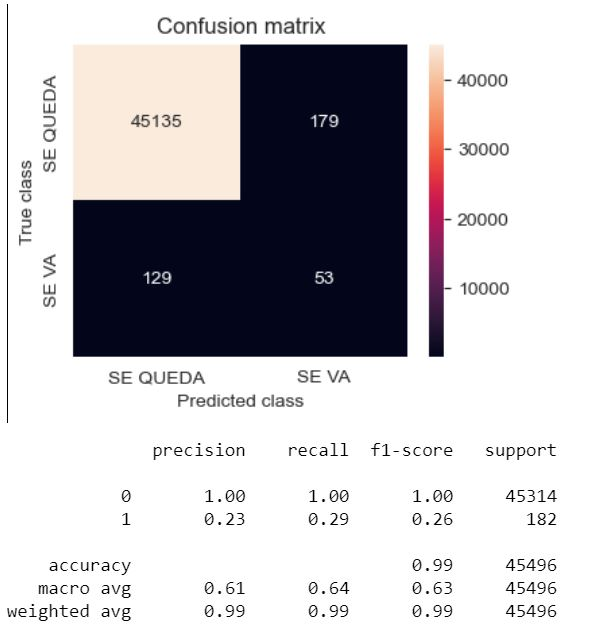

## Validación cruzada interna y Optimización de los hiperparámetros

In [ ]:
algoritmos['LOGR'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 4000,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 1,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
LOGR_pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=1)],
                                #['scaler', StandardScaler()],
                                #['scaler', MinMaxScaler()],
                                ['classifier', algoritmos['LOGR']]])

#param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
LOGR_param_grid = {'classifier__C':[0.01, 0.1, 1, 10]}
LOGR_model_bal = GridSearchCV(estimator=LOGR_pipeline,
                           param_grid=LOGR_param_grid,
                           scoring='roc_auc',
                           cv=LOGR_cv,
                           n_jobs=-1)

LOGR_model_bal.fit(LOGR_Xnew_train, LOGR_y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=1)],
                                       ['classifier',
                                        LogisticRegression(max_iter=4000,
                                                           multi_class='ovr',
                                                           penalty='l1',
                                                           random_state=1,
                                                           solver='saga')]]),
             n_jobs=-1, param_grid={'classifier__C': [0.01, 0.1, 1, 10]},
             scoring='roc_auc')

In [ ]:
LOGR_model_bal.best_params_

{'classifier__C': 0.01}

In [ ]:
LOGR_cv_results = pd.DataFrame(LOGR_model_bal.cv_results_)
#cv_results.head()

In [ ]:
LOGR_cv_results_tiny = LOGR_cv_results[['param_classifier__C', 'mean_test_score', 'std_test_score', 'rank_test_score']]
LOGR_cv_results_tiny.sort_values(by='mean_test_score', ascending=False).head()

,param_classifier__C,mean_test_score,std_test_score,rank_test_score
0,0.01,0.907961,0.008453,1
1,0.1,0.905367,0.009642,2
2,1,0.904798,0.009496,3
3,10,0.904721,0.009473,4


## ------------- PREDICTION ----------------

## Predicción del conjunto de test

In [ ]:
LOGR_y_test_pred_bal =  LOGR_model_bal.predict(LOGR_Xnew_test) 

#### Chequeamos respuesta del modelo (Con el entrenamiento balanceado)

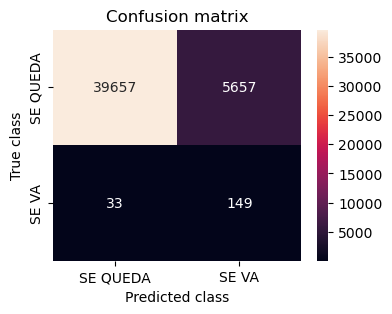

              precision    recall  f1-score   support

           0       1.00      0.88      0.93     45314
           1       0.03      0.82      0.05       182

    accuracy                           0.87     45496
   macro avg       0.51      0.85      0.49     45496
weighted avg       1.00      0.87      0.93     45496



In [ ]:
mostrar_resultados(LOGR_y_test, LOGR_y_test_pred_bal)

## Evaluación del modelo sobre el conjunto de test

In [ ]:
LOGR_y_train_pred_bal = LOGR_model_bal.predict(LOGR_Xnew_train) 

In [ ]:
#Ahora puedo obtener Recall y Precision
print('Accuracy')
print('Train:',accuracy_score(LOGR_y_train, LOGR_y_train_pred_bal))
print('Test:',accuracy_score(LOGR_y_test, LOGR_y_test_pred_bal))
print(' ')
print('Recall')
print('Train:',recall_score(LOGR_y_train, LOGR_y_train_pred_bal))
print('Test:',recall_score(LOGR_y_test, LOGR_y_test_pred_bal))
print(' ')
print('Precision')
print('Train:',precision_score(LOGR_y_train, LOGR_y_train_pred_bal))
print('Test:',precision_score(LOGR_y_test, LOGR_y_test_pred_bal))

Accuracy
Train: 0.8763527127523171
Test: 0.8749340601371549
 
Recall
Train: 0.8640939597315436
Test: 0.8186813186813187
 
Precision
Train: 0.02975158867706528
Test: 0.0256631071305546


#### Matriz de confusión sobre train

In [ ]:
confusion_matrix(LOGR_y_train, LOGR_y_train_pred_bal)

array([[119094,  16795],
       [    81,    515]], dtype=int64)

#### Matriz de confusión sobre test

In [ ]:
confusion_matrix(LOGR_y_test, LOGR_y_test_pred_bal)

array([[39657,  5657],
       [   33,   149]], dtype=int64)

## Ploteamos la curva ROC

In [ ]:
LOGR_y_score2 = LOGR_model_bal.predict_proba(LOGR_Xnew_train)[:,1]
LOGR_false_positive_rate2, LOGR_true_positive_rate2, LOGR_threshold2 = roc_curve(LOGR_y_train, LOGR_y_score2)
print('roc_auc_score para LogisticRegression: ', roc_auc_score(LOGR_y_train, LOGR_y_score2))

roc_auc_score para LogisticRegression:  0.9370162387274137


In [ ]:
LOGR_y_score1 = LOGR_model_bal.predict_proba(LOGR_Xnew_test)[:,1]
LOGR_false_positive_rate1, LOGR_true_positive_rate1, LOGR_threshold1 = roc_curve(LOGR_y_test, LOGR_y_score1)
print('roc_auc_score para LogisticRegression: ', roc_auc_score(LOGR_y_test, LOGR_y_score1))

roc_auc_score para LogisticRegression:  0.9232634117879295


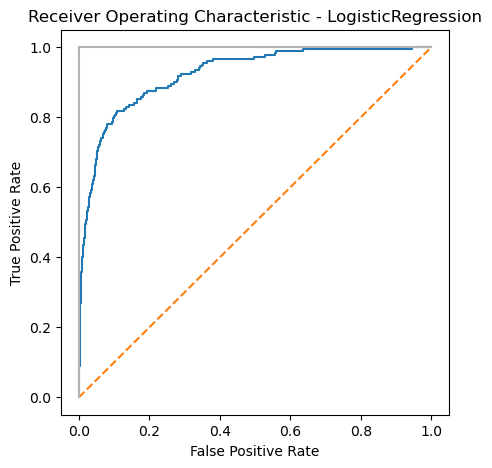

In [ ]:
# Plot ROC curves
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - LogisticRegression')
plt.plot(LOGR_false_positive_rate1, LOGR_true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Generación csv Valorización

In [ ]:
LOGR_y_pred = LOGR_model_bal.predict_proba(LOGR_Xnew_test)[:, 1] 
LOGR_y_pred_bin = LOGR_model_bal.predict(LOGR_Xnew_test) 

In [ ]:
LOGR_y_pred_20 = []
for n in LOGR_y_pred:
    LOGR_y_pred_20.append(format(n, ".20f"))  
    
LOGR_y_pred_s = pd.Series(LOGR_y_pred_20, index=LOGR_y_test.index.tolist())
LOGR_y_pred_bin_s = pd.Series(LOGR_y_pred_bin, index=LOGR_y_test.index.tolist())

In [ ]:
LOGR_finalDf= pd.concat([
LOGR_df2.loc[LOGR_y_test.index.tolist(),['numero_de_cliente','target_bin']],
pd.DataFrame(LOGR_y_pred_bin_s, columns=['Pred']),
pd.DataFrame(LOGR_y_pred_s, columns=['Proba'])
], axis=1)
LOGR_finalDf

,numero_de_cliente,target_bin,Pred,Proba
18909,7505074,0,0,0.14778212639368143444
75459,17925709,0,0,0.00820298129689062648
172951,41097326,0,0,0.09427098915917102306
16316,7255698,0,0,0.08546771792851222405
143242,30057908,0,0,0.02104071140328840281
...,...,...,...,...
126650,26335728,0,0,0.00215265562684903563
127905,26556502,0,0,0.02541559217295844691
127622,26509225,0,0,0.01013005727335304813
92117,21433251,0,0,0.20359324784752491633


In [ ]:
LOGR_finalDf['Proba'].astype(float)

18909     0.147782
75459     0.008203
172951    0.094271
16316     0.085468
143242    0.021041
            ...   
126650    0.002153
127905    0.025416
127622    0.010130
92117     0.203593
73809     0.005000
Name: Proba, Length: 45496, dtype: float64

In [ ]:
#LOGR_finalDf.to_csv('./LOGR_c150_1.csv')
LOGR_finalDf.to_csv('/content/drive/MyDrive/B3/Final/LOGR_c150_1.csv')

## Conclusión Modelo de Regresión Logística

#### El pico máximo de ganancia en la curva nos da un total de 393700, llevando este valor para buscar la probabilidad da un valor de 74,69%. 
#### El threshold debería estar en 0.7469.


# **Gradient Boosting**

Gradient Boosted Regression Trees es un método de ensemble donde se van construyendo árboles de decisión sencillos y se evalúan sus errorres. Posteriormente se vuelven a construir nuevos árboles pero mejorando la performance de los anteriores y así recurrentemente hasta tener un modelo completo. Es un método muy poderoso y ampliamente usado. Como contra tiene que hay que sintonizar muchos parámetros para que el modelo adquiera una performance óptima (con el consecuente tiempo de análisis y computacional).

In [ ]:
path = '/content/drive/My Drive/Grupo1/B3/Final'
df2 = pd.read_csv(path + '/DF150.csv')


In [ ]:
df2.head()

,Unnamed: 0,numero_de_cliente,foto_mes,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,marketing_coss_selling,...,MCE_10,MCE_11,MCE_12,MCE_19,VMA_0,VMA_1,VCE_10,VCE_11,VCE_12,VCE_19
0,22,5609788,201402,0,224,61,237,0.00,9669.42,8,...,1,0,0,0,1,0,1,0,0,0
1,38,5609981,201402,0,227,64,196,0.00,4107.16,9,...,1,0,0,0,1,0,1,0,0,0
2,54,5610023,201402,0,536,41,91,0.00,2888.84,9,...,1,0,0,0,1,0,1,0,0,0
3,70,5610089,201402,0,545,0,237,2597.43,0.00,12,...,1,0,0,0,1,0,1,0,0,0
4,86,5610101,201402,0,1217,49,45,0.00,46303.03,11,...,1,0,0,0,1,0,1,0,0,0


In [ ]:
# Elimino la primer columna
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]

In [ ]:
print(df2.shape)


(181981, 150)


### **Creamos los set de train y test**

In [ ]:
X = df2.drop(['target_bin'] , axis='columns')
y = df2.target_bin

print(X.shape)
print(y.shape)

(181981, 149)
(181981,)


In [ ]:
# Tomo X y de Creamos los set de train y test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)


(136485, 149)
(45496, 149)


## **Grid Search**

Uno de los requisitos del Gradient Boosting es sintonizar los parámetros principales para que el modelo adquiera una performance óptima.

En nuestro caso tomaremos como fijos los siguientes parámetros:
- `n_estimators`: **5000** Máximo número árboles en el modelo
- `validation_fraction`: **10%** de las observaciones serán usadas para validación
- `n_iter_no_change`: **20** criterio que para el training: si no se observaron cambios de performance en 20 iteraciones el training se para
- `max_features`: **log2(# features)** 

Como parámetros variables (se irán cambiando en sucesivos modelos en la Grilla):
- `learning_rate`: es el peso asignado a cada árbol de predicción construído. Ensayaremos los valores: [0.05, 0.1]
- `max_depth`: máxima profundidad de los árboles contruídos en el modelo. Ensayaremos los valores: [2, 3, 5]
- `subsample`: porcentaje de observaciones que serán usadas para construir los árboles individuales. Ensayaremos los valores: [0.5, 0.8]

Usaremos GradientBoostingClassifier con GridSeearchCV (con cross validation).

In [ ]:
# Buscamos parámetros con Grid Search
parametros = {'learning_rate': [0.5, 0.1], 'max_depth': [2, 3, 5], 'subsample': [0.5, 0.8]}

grid = GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=5000, validation_fraction=0.1, n_iter_no_change=20, max_features='log2',
                      verbose=1, random_state=1, min_samples_split=500, min_samples_leaf=50), param_grid=parametros, scoring='roc_auc', cv=5)

grid.fit(X_train, y_train)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0513           0.0056            5.35m
         2           0.0484           0.0012            5.30m
         3           0.0465           0.0020            4.98m
         4           0.0437           0.0020            5.19m
         5           0.0439           0.0001            5.04m
         6           0.0441           0.0010            5.11m
         7           0.0460          -0.0007            5.25m
         8           0.0440           0.0005            5.38m
         9           0.0435           0.0000            5.28m
        10           0.0410           0.0003            5.30m
        20           0.0407           0.0001            5.11m
        30           0.0390          -0.0000            5.06m
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0513           0.0052            5.48m
         2           0.0493           0.0010            5.57m
      

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='log2',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  n_estimators=5000,
                                                  n_iter_no_change=20,
                                                  random_state=1, verbose=1),
             param_grid={'learning_rate': [0.5, 0.1], 'max_depth': [2, 3, 5],
                         'subsample': [0.5, 0.8]},
             scoring='roc_auc')

In [ ]:
print ('Best Score: {:.2f}', grid.best_score_)


Best Score: {:.2f} 0.9200794196217184


In [ ]:
grid.best_params_


{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}

## **Gradient Boost - Modelo 1 - Datos sin balancear**

Parámetros óptimos encontrados por GridSearch: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}

Utilizando estos parámetros óptimos entrenamos un modelo usando los datos originales sin balancear las clases.

In [ ]:
# Con los parámetros anteriores entrenamos un GBoost
gbm1 = GradientBoostingClassifier(n_estimators=5000,
                                       learning_rate=0.1,
                                       max_depth=3,
                                       subsample=0.8,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       max_features='log2',
                                       verbose=1, random_state=1)
gbm1.fit(X_train, y_train)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0520           0.0035           12.73m
         2           0.0491           0.0008           11.53m
         3           0.0502          -0.0009           11.78m
         4           0.0480          -0.0000           11.78m
         5           0.0489           0.0003           11.47m
         6           0.0457           0.0005           12.11m
         7           0.0472           0.0006           11.72m
         8           0.0470           0.0004           12.08m
         9           0.0461           0.0002           11.79m
        10           0.0470           0.0004           11.65m
        20           0.0430           0.0000           11.17m
        30           0.0409           0.0001           11.07m
        40           0.0395           0.0001           11.02m
        50           0.0407           0.0000           10.89m
        60           0.0388           0.0001           10.97m
       

GradientBoostingClassifier(max_features='log2', n_estimators=5000,
                           n_iter_no_change=20, random_state=1, subsample=0.8,
                           verbose=1)

In [ ]:
len(gbm1.estimators_)


182

In [ ]:
y_train_pb1 = gbm1.predict_proba(X_train)[:,1]
y_test_pb1 = gbm1.predict_proba(X_test)[:,1]

y_train_pred1 = gbm1.predict(X_train)
y_test_pred1 = gbm1.predict(X_test)

print("AUC Train: {:.4f}\nAUC Test: {:.4f} \n".format(roc_auc_score(y_train, y_train_pb1),
                                                    roc_auc_score(y_test, y_test_pb1)))

print('Accuracy: Train: %.4f - Test: %.4f \n' % (accuracy_score(y_train, y_train_pred1), accuracy_score(y_test, y_test_pred1)))
print('Recall: Train: %.4f - Test: %.4f \n' % (recall_score(y_train, y_train_pred1), recall_score(y_test, y_test_pred1)))
print('Precision: Train: %.4f - Test: %.4f \n' % (precision_score(y_train, y_train_pred1), precision_score(y_test, y_test_pred1)))

fpr_test1, tpr_test1, threshold1 = roc_curve(y_test, y_test_pb1)


AUC Train: 0.9464
AUC Test: 0.9355 

Accuracy: Train: 0.9958 - Test: 0.9954 

Recall: Train: 0.1678 - Test: 0.0659 

Precision: Train: 0.5848 - Test: 0.2264 



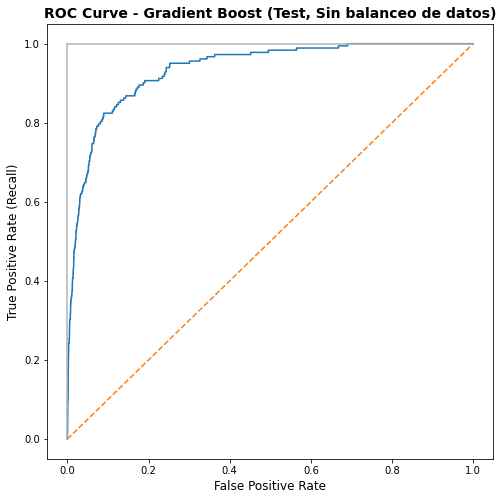

In [ ]:
# Plot ROC curves
plt.subplots(1, figsize=(8, 8))
plt.title('ROC Curve - Gradient Boost (Test, Sin balanceo de datos)', fontsize=14, fontweight="bold")
plt.plot(fpr_test1, tpr_test1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.show()


In [ ]:
ganancia, threshold = ThresholdOptimo(y_test_pb1, y_test)

print('Ganancia Estimada: %.0f \nThreshold: %.4f' % (ganancia, threshold))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Ganancia Estimada: 406100 
Threshold: 0.0210


In [ ]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb1)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProbaBoost1.xlsx')


In [ ]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(gbm1, path + '/GBoost1.joblib') 


['/content/drive/My Drive/Grupo1/B3/Final/GBoost1.joblib']

**Conclusión Gradient Boost - Modelo 1**

Viendo la Curva ROC y con un AUC-ROC en Test de 0.9355 parece ser un modelo muy apto para nuestra clasificación.

Ganancia Estimada: 406.100 - Threshold: 0.0210

## **Gradient Boost - Modelo 2 - Datos balanceados**

Parámetros óptimos encontrados por GridSearch: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}

Utilizando los mismos parámetros óptimos anteriores entrenamos otro modelo usando los datos previamente balanceando las clases con SMOTE.

In [ ]:
# import library
from collections import Counter
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(random_state=1)
X2_train, y2_train = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y2_train)
print(counter)

print(X2_train.shape)

Counter({0: 135889, 1: 135889})
(271778, 149)


In [ ]:
# Con los parámetros anteriores entrenamos un GBoost
gbm2 = GradientBoostingClassifier(n_estimators=5000,
                                       learning_rate=0.1,
                                       max_depth=3,
                                       subsample=0.8,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       max_features='log2',
                                       verbose=1, random_state=1)
gbm2.fit(X2_train, y2_train)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2831           0.1021           23.94m
         2           1.1996           0.0824           28.24m
         3           1.1125           0.0872           28.57m
         4           1.0491           0.0628           27.92m
         5           0.9940           0.0551           27.13m
         6           0.9492           0.0454           26.36m
         7           0.9064           0.0429           25.65m
         8           0.8750           0.0321           25.90m
         9           0.8472           0.0273           25.60m
        10           0.8109           0.0363           25.18m
        20           0.6058           0.0103           26.76m
        30           0.4857           0.0089           31.27m
        40           0.4130           0.0067           34.27m
        50           0.3599           0.0046           33.84m
        60           0.3190           0.0037           37.14m
       

GradientBoostingClassifier(max_features='log2', n_estimators=5000,
                           n_iter_no_change=20, random_state=1, subsample=0.8,
                           verbose=1)

In [ ]:
len(gbm2.estimators_)


870

In [ ]:
y_train_pb2 = gbm2.predict_proba(X2_train)[:,1]
y_test_pb2 = gbm2.predict_proba(X_test)[:,1]

y_train_pred2 = gbm2.predict(X2_train)
y_test_pred2 = gbm2.predict(X_test)

print("AUC Train: {:.4f}\nAUC Test: {:.4f} \n".format(roc_auc_score(y2_train, y_train_pb2),
                                                    roc_auc_score(y_test, y_test_pb2)))

print('Accuracy: Train: %.4f - Test: %.4f \n' % (accuracy_score(y2_train, y_train_pred2), accuracy_score(y_test, y_test_pred2)))
print('Recall: Train: %.4f - Test: %.4f \n' % (recall_score(y2_train, y_train_pred2), recall_score(y_test, y_test_pred2)))
print('Precision: Train: %.4f - Test: %.4f \n' % (precision_score(y2_train, y_train_pred2), precision_score(y_test, y_test_pred2)))

fpr_test2, tpr_test2, threshold2 = roc_curve(y_test, y_test_pb2)


AUC Train: 0.9994
AUC Test: 0.8865 

Accuracy: Train: 0.9971 - Test: 0.9933 

Recall: Train: 0.9965 - Test: 0.1374 

Precision: Train: 0.9976 - Test: 0.1445 



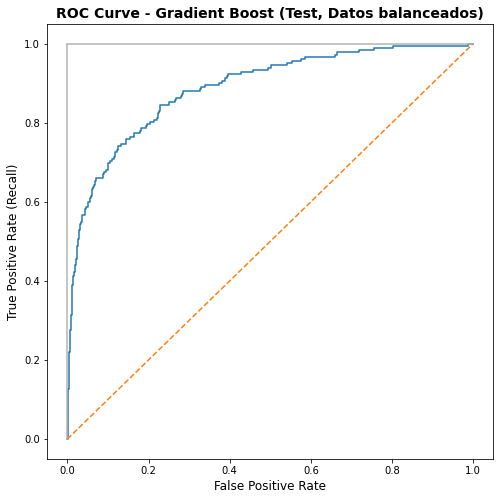

In [ ]:
# Plot ROC curves
plt.subplots(1, figsize=(8, 8))
plt.title('ROC Curve - Gradient Boost (Test, Datos balanceados)', fontsize=14, fontweight="bold")
plt.plot(fpr_test2, tpr_test2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.show()


In [ ]:
ganancia, threshold = ThresholdOptimo(y_test_pb2, y_test)

print('Ganancia Estimada: %.0f \nThreshold: %.4f' % (ganancia, threshold))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Ganancia Estimada: 342900 
Threshold: 0.0793


In [ ]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb2)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProbaBoost2.xlsx')


In [ ]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(gbm2, path + '/GBoost2.joblib') 


['/content/drive/My Drive/Grupo1/B3/Final/GBoost2.joblib']

**Conclusión Gradient Boost - Modelo 2**

Viendo la Curva ROC y con un AUC-ROC en Test de 0.8865 indica que este modelo clasifica de peor manera que el anterior.

Ganancia Estimada: 342.900 - Threshold: 0.0793

## **Random Forest (Balanceado)**

Vamos a entrenar un Random Forest con valores de parámetros estandard.

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=5, class_weight='balanced', max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, max_leaf_nodes=16,
                       n_estimators=500, n_jobs=-1)

In [ ]:
y_train_pb3 = rnd_clf.predict_proba(X_train)[:,1]
y_test_pb3 = rnd_clf.predict_proba(X_test)[:,1]

y_train_pred3 = rnd_clf.predict(X_train)
y_test_pred3 = rnd_clf.predict(X_test)

print("AUC Train: {:.4f}\nAUC Test: {:.4f} \n".format(roc_auc_score(y_train, y_train_pb3),
                                                    roc_auc_score(y_test, y_test_pb3)))

print('Accuracy: Train: %.4f - Test: %.4f \n' % (accuracy_score(y_train, y_train_pred3), accuracy_score(y_test, y_test_pred3)))
print('Recall: Train: %.4f - Test: %.4f \n' % (recall_score(y_train, y_train_pred3), recall_score(y_test, y_test_pred3)))
print('Precision: Train: %.4f - Test: %.4f \n' % (precision_score(y_train, y_train_pred3), precision_score(y_test, y_test_pred3)))

fpr_test3, tpr_test3, threshold3 = roc_curve(y_test, y_test_pb3)


AUC Train: 0.9341
AUC Test: 0.9279 

Accuracy: Train: 0.8824 - Test: 0.8829 

Recall: Train: 0.8473 - Test: 0.8132 

Precision: Train: 0.0307 - Test: 0.0272 



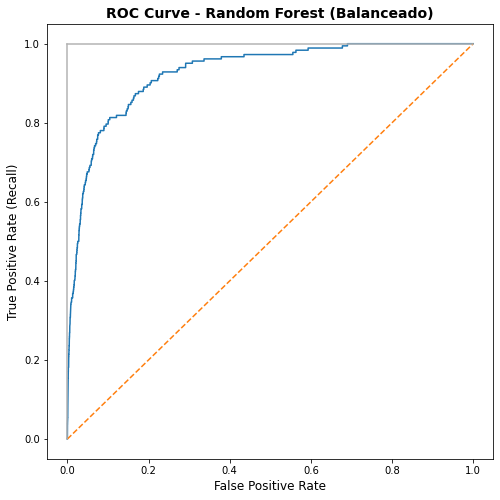

In [ ]:
# Plot ROC curves
plt.subplots(1, figsize=(8, 8))
plt.title('ROC Curve - Random Forest (Balanceado)', fontsize=14, fontweight="bold")
plt.plot(fpr_test3, tpr_test3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.show()


In [ ]:
ganancia, threshold = ThresholdOptimo(y_test_pb3, y_test)

print('Ganancia Estimada: %.0f \nThreshold: %.4f' % (ganancia, threshold))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Ganancia Estimada: 384400 
Threshold: 0.7807


In [ ]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb3)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProbaRF.xlsx')


In [ ]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(rnd_clf, path + '/RandomForest.joblib') 


['/content/drive/My Drive/Grupo1/B3/Final/RandomForest.joblib']

**Conclusión Random Forest Balanceado**

Viendo la Curva ROC y con un AUC-ROC en Test de 0.9279 indica que es un muy buen modelo, de los mejores que hamos obtenido.

Ganancia Estimada: 384.400 - Threshold: 0.7807

In [ ]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load

dump(rnd_clf, path + '/RFModel.joblib') 


['/content/drive/My Drive/Grupo1/B3/Final/RFModel.joblib']

## **Modelos ML - Conclusión final**

De todos los modelos entrenados tenemos varios modelos con métricas muy buenas. Buscando el modelo que maximiza la ganacia tenemos:

*   Gradient Boost 1: 406.100 (Threshold: 0.0210)
*   Regresión Logística: 393.700
*   Random Forest: 384.400
*   Gradient Boost 2: 342.900
*   Arbol: 317.900

Elegimos el modelo de Gradient Boost 1 (GBoost1.joblib en disco) pero hay varios modelos que están muy parejos en performance.










-----------------------------------------------------

###Comparación / Validación con Herramienta de AutoML: TPOT
TPOT ofrece un modelo que presenta un score similar, pero aún así el GradientBoost elegido anteriormente tiene mejores métricas.

Al ser similares los valores a los obtenidos, se validan las decisiones adoptadas para el modelo seleccionado.

https://epistasislab.github.io/tpot/using/


In [ ]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 6.9 MB/s 
     |████████████████████████████████| 255.9 MB 65 kB/s 
     |████████████████████████████████| 139 kB 94.3 MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=721f3da188842a4375365db710b75a8fcfcb559e92fda576b72bec18077b2b01
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from sklearn.metrics import make_scorer
from tpot import TPOTClassifier

In [ ]:
#Usamos el DF con los Registros Balanceados - Con Scorer ROC_AUC
#Fuente:  https://epistasislab.github.io/tpot/using/

tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,n_jobs=-1, random_state=1,
                      scoring="roc_auc",max_time_mins=30)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

In [ ]:
#Recomienda Usar: GradientBoostingClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectPercentile, chi2
etc = GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=0.25, min_samples_leaf=2, min_samples_split=3, n_estimators=100, subsample=0.5, random_state=1)
etc.fit(X_train, y_train)

Según la herramenta TPOT el modelo recomendado es un clasificador Gradient Boost y nos sugiere los mejores ajustes calculados para los hiperparametros, lo que permite un tunneo más fino del algoritmo y obtener mejores métricas.
 